# Tipping Psychology Analysis

## Business Case: Driver Revenue Optimization

**Key Question:** Which trip characteristics correlate with higher tips? Is it affluent neighborhoods, longer distances, or other factors?

## Objectives
- Calculate tip percentages across different trip types
- Identify relationship between trip distance and tipping behavior
- Analyze location-based tipping patterns
- Provide drivers with actionable insights to maximize earnings

## Business Impact
Understanding tipping patterns enables:
- Driver coaching on high-value trip selection
- Route optimization for revenue maximization
- Improved driver satisfaction and retention
- Foundation for Driver Insights features (Phase 5)

## Important Note
Analysis focuses on **credit card payments only**, as cash tips are typically not recorded in the system.

## Setup & Data Loading

In [1]:
import os

import plotly.express as px
import plotly.graph_objects as go
import polars as pl

px.defaults.template = 'plotly_white'

In [2]:
uri = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST')}:5432/{os.getenv('POSTGRES_DB')}"

In [3]:
# 1. Load Financial Data
# Note: We filter for Credit Card (payment_type=1) because cash tips are often not recorded!
query = """
SELECT 
    trip_distance, fare_amount, tip_amount, 
    pickup_location_id, payment_type_description
FROM dbt_dev.fct_trips
WHERE payment_type_description = 'Credit Card'
  AND fare_amount > 0
LIMIT 500000
"""
df = pl.read_database_uri(query, uri, engine="connectorx")

## Tip Percentage Calculation

Create normalized metric (tip % of fare) to enable fair comparison across different fare amounts.

In [4]:
# Calculate Tip Percentage
df = df.with_columns(
    (pl.col("tip_amount") / pl.col("fare_amount") * 100).alias("tip_pct")
)

# Filter outliers for better visualization (0-50% tip range)
df_clean = df.filter((pl.col("tip_pct") >= 0) & (pl.col("tip_pct") <= 50))

print(f"Data shape: {df_clean.shape}")
print(f"\nTip Statistics:")
print(df_clean.select(pl.col("tip_pct")).describe())

Data shape: (490954, 6)

Tip Statistics:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ tip_pct   │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 490954.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 25.204244 │
│ std        ┆ 10.788388 │
│ min        ┆ 0.0       │
│ 25%        ┆ 20.0      │
│ 50%        ┆ 27.017544 │
│ 75%        ┆ 32.0      │
│ max        ┆ 50.0      │
└────────────┴───────────┘


## Distance vs Tipping Behavior

**Finding:** Analyze whether longer trips result in higher or lower tip percentages.

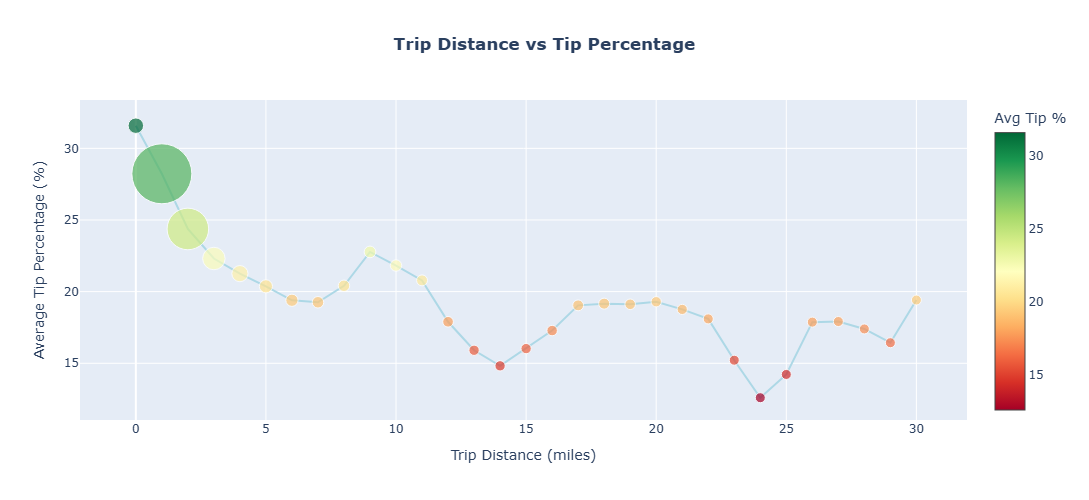


💡 Bubble size represents trip volume at each distance


In [5]:
# Distance vs Tip Percentage Analysis
df_binned = df_clean.with_columns(
    pl.col("trip_distance").round(0).cast(pl.Int32).alias("distance_bin")
).filter(pl.col("distance_bin") <= 30)  # Focus on reasonable distances

distance_tips = df_binned.group_by("distance_bin").agg([
    pl.col("tip_pct").mean().alias("avg_tip_pct"),
    pl.col("tip_pct").count().alias("count")
]).sort("distance_bin").to_pandas()

fig = go.Figure()

# Add scatter with size based on count
fig.add_trace(go.Scatter(
    x=distance_tips['distance_bin'],
    y=distance_tips['avg_tip_pct'],
    mode='markers+lines',
    marker=dict(
        size=distance_tips['count']/distance_tips['count'].max()*50 + 10,
        color=distance_tips['avg_tip_pct'],
        colorscale='RdYlGn',
        showscale=True,
        colorbar=dict(title='Avg Tip %'),
        line=dict(width=1, color='white')
    ),
    line=dict(width=2, color='lightblue'),
    hovertemplate='<b>Distance:</b> %{x} miles<br><b>Avg Tip:</b> %{y:.1f}%<br><b>Trips:</b> %{text:,}<extra></extra>',
    text=distance_tips['count']
))

fig.update_layout(
    title=dict(text='<b>Trip Distance vs Tip Percentage</b>', x=0.5, xanchor='center'),
    xaxis_title='Trip Distance (miles)',
    yaxis_title='Average Tip Percentage (%)',
    height=500,
    hovermode='closest'
)
fig.show()

print(f"\n💡 Bubble size represents trip volume at each distance")

## Location-Based Tipping Patterns

**Finding:** Identify pickup zones with the most generous tippers to guide driver positioning.

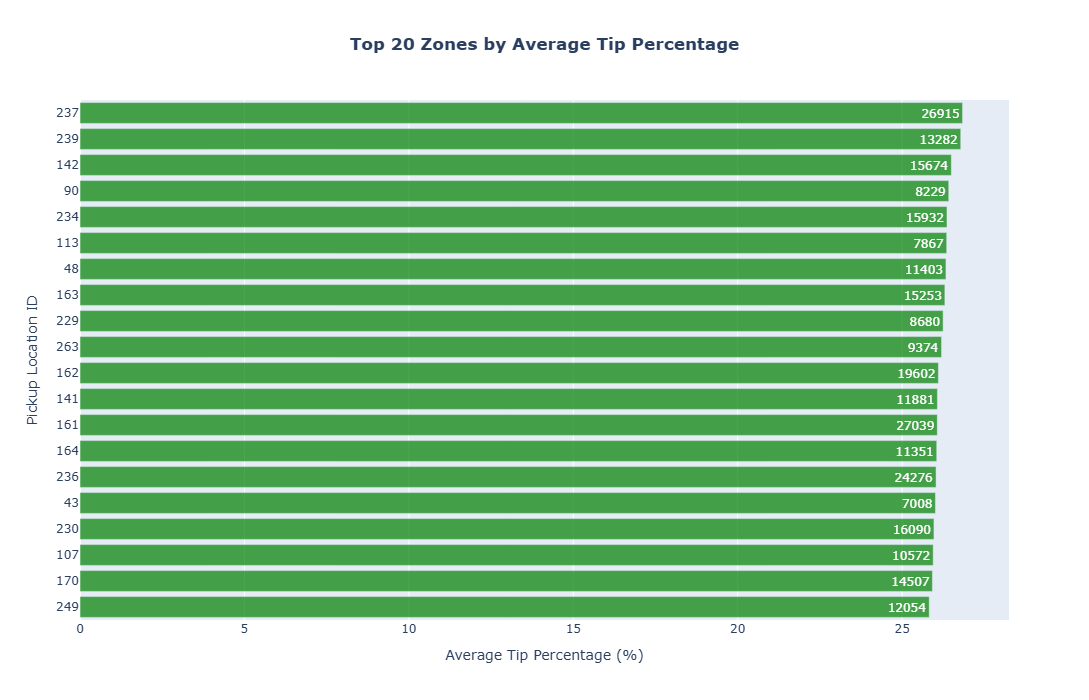


💰 Best tipping zone: ID 237.0 (26.8% avg)
📊 Based on zones with 100+ trips for statistical reliability


In [6]:
# Top Tipping Zones
zone_tips = df_clean.group_by("pickup_location_id").agg([
    pl.col("tip_pct").mean().alias("avg_tip_pct"),
    pl.col("tip_pct").count().alias("trip_count")
]).filter(pl.col("trip_count") >= 100)  # Minimum sample size

top_zones = zone_tips.sort("avg_tip_pct", descending=True).head(20).to_pandas()
bottom_zones = zone_tips.sort("avg_tip_pct").head(20).to_pandas()

fig = go.Figure()

# Top tippers
fig.add_trace(go.Bar(
    y=top_zones['pickup_location_id'].astype(str),
    x=top_zones['avg_tip_pct'],
    orientation='h',
    name='Top Tippers',
    marker=dict(color='green', opacity=0.7),
    hovertemplate='<b>Zone:</b> %{y}<br><b>Avg Tip:</b> %{x:.1f}%<br><b>Trips:</b> %{text:,}<extra></extra>',
    text=top_zones['trip_count']
))

fig.update_layout(
    title=dict(text='<b>Top 20 Zones by Average Tip Percentage</b>', x=0.5, xanchor='center'),
    xaxis_title='Average Tip Percentage (%)',
    yaxis_title='Pickup Location ID',
    height=700,
    showlegend=False,
    yaxis=dict(autorange='reversed')
)
fig.show()

print(f"\n💰 Best tipping zone: ID {top_zones.iloc[0]['pickup_location_id']} ({top_zones.iloc[0]['avg_tip_pct']:.1f}% avg)")
print(f"📊 Based on zones with 100+ trips for statistical reliability")